<a href="https://colab.research.google.com/github/ArnobRahee/A2AA/blob/main/Pytorch_and_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Downloading JRAPH**

In [1]:
!pip install git+https://github.com/deepmind/jraph.git
!pip install flax
!pip install dm-haiku

  Cloning https://github.com/deepmind/jraph.git to /tmp/pip-req-build-exj6605l
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/jraph.git /tmp/pip-req-build-exj6605l
  Resolved https://github.com/deepmind/jraph.git to commit 51f5990104f7374492f8f3ea1cbc47feb411c69c
  Preparing metadata (setup.py) ... done
  Created wheel for jraph: filename=jraph-0.0.6.dev0-py3-none-any.whl size=91245 sha256=c261ca6e8df3b1f56ef5113091634867aa175ce90d19715d928f04d7f8f6c42f
  Stored in directory: /tmp/pip-ephem-wheel-cache-8527d7q4/wheels/76/61/34/8fb9aa4dac00d471de4a5f7157614181de683c445fc2d640db
Successfully built jraph
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.0/371.0 kB 7.1 MB/s eta 0:00:00


*Importing Libraries of both pytorch and JAX**

In [2]:
## Standard libraries
import os
import json
import math
import numpy as np
import time
import pickle
## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()
#JRAPH
%matplotlib inline
import functools
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.tree_util as tree
import jraph
import flax
import haiku as hk
import optax
import pickle
import numpy as onp
import networkx as nx
from typing import Any, Callable, Dict, List, Optional, Tuple


## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial7"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

<ipython-input-2-57afe3eada42>:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


cpu


In [4]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial7/"
# Files to download
pretrained_files = ["NodeLevelMLP.ckpt", "NodeLevelGNN.ckpt", "GraphLevelGraphConv.ckpt"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

**Pytorch**

In [5]:
class GCNLayer(nn.Module):

    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """
        Inputs:
            node_feats - Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections.
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix, node_feats)
        node_feats = node_feats / num_neighbours
        return node_feats

In [6]:
node_feats = torch.arange(8, dtype=torch.float32).view(1, 4, 2)
adj_matrix = torch.Tensor([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])

print("Node features:\n", node_feats)
print("\nAdjacency matrix:\n", adj_matrix)

Node features:
 tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])

Adjacency matrix:
 tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])


In [7]:
class GATLayer(nn.Module):

    def __init__(self, c_in, c_out, num_heads=1, concat_heads=True, alpha=0.2):
        """
        Inputs:
            c_in - Dimensionality of input features
            c_out - Dimensionality of output features
            num_heads - Number of heads, i.e. attention mechanisms to apply in parallel. The
                        output features are equally split up over the heads if concat_heads=True.
            concat_heads - If True, the output of the different heads is concatenated instead of averaged.
            alpha - Negative slope of the LeakyReLU activation.
        """
        super().__init__()
        self.num_heads = num_heads
        self.concat_heads = concat_heads
        if self.concat_heads:
            assert c_out % num_heads == 0, "Number of output features must be a multiple of the count of heads."
            c_out = c_out // num_heads

        # Sub-modules and parameters needed in the layer
        self.projection = nn.Linear(c_in, c_out * num_heads)
        self.a = nn.Parameter(torch.Tensor(num_heads, 2 * c_out)) # One per head
        self.leakyrelu = nn.LeakyReLU(alpha)

        # Initialization from the original implementation
        nn.init.xavier_uniform_(self.projection.weight.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

    def forward(self, node_feats, adj_matrix, print_attn_probs=False):
        """
        Inputs:
            node_feats - Input features of the node. Shape: [batch_size, c_in]
            adj_matrix - Adjacency matrix including self-connections. Shape: [batch_size, num_nodes, num_nodes]
            print_attn_probs - If True, the attention weights are printed during the forward pass (for debugging purposes)
        """
        batch_size, num_nodes = node_feats.size(0), node_feats.size(1)

        # Apply linear layer and sort nodes by head
        node_feats = self.projection(node_feats)
        node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1)

        # We need to calculate the attention logits for every edge in the adjacency matrix
        # Doing this on all possible combinations of nodes is very expensive
        # => Create a tensor of [W*h_i||W*h_j] with i and j being the indices of all edges
        edges = adj_matrix.nonzero(as_tuple=False) # Returns indices where the adjacency matrix is not 0 => edges
        node_feats_flat = node_feats.view(batch_size * num_nodes, self.num_heads, -1)
        edge_indices_row = edges[:,0] * num_nodes + edges[:,1]
        edge_indices_col = edges[:,0] * num_nodes + edges[:,2]
        a_input = torch.cat([
            torch.index_select(input=node_feats_flat, index=edge_indices_row, dim=0),
            torch.index_select(input=node_feats_flat, index=edge_indices_col, dim=0)
        ], dim=-1) # Index select returns a tensor with node_feats_flat being indexed at the desired positions along dim=0

        # Calculate attention MLP output (independent for each head)
        attn_logits = torch.einsum('bhc,hc->bh', a_input, self.a)
        attn_logits = self.leakyrelu(attn_logits)

        # Map list of attention values back into a matrix
        attn_matrix = attn_logits.new_zeros(adj_matrix.shape+(self.num_heads,)).fill_(-9e15)
        attn_matrix[adj_matrix[...,None].repeat(1,1,1,self.num_heads) == 1] = attn_logits.reshape(-1)

        # Weighted average of attention
        attn_probs = F.softmax(attn_matrix, dim=2)
        if print_attn_probs:
            print("Attention probs\n", attn_probs.permute(0, 3, 1, 2))
        node_feats = torch.einsum('bijh,bjhc->bihc', attn_probs, node_feats)

        # If heads should be concatenated, we can do this by reshaping. Otherwise, take mean
        if self.concat_heads:
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:
            node_feats = node_feats.mean(dim=2)

        return node_feats

In [8]:
layer = GATLayer(2, 2, num_heads=2)
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])
layer.a.data = torch.Tensor([[-0.2, 0.3], [0.1, -0.1]])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix, print_attn_probs=True)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

Attention probs
 tensor([[[[0.3543, 0.6457, 0.0000, 0.0000],
          [0.1096, 0.1450, 0.2642, 0.4813],
          [0.0000, 0.1858, 0.2885, 0.5257],
          [0.0000, 0.2391, 0.2696, 0.4913]],

         [[0.5100, 0.4900, 0.0000, 0.0000],
          [0.2975, 0.2436, 0.2340, 0.2249],
          [0.0000, 0.3838, 0.3142, 0.3019],
          [0.0000, 0.4018, 0.3289, 0.2693]]]])
Adjacency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input features tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output features tensor([[[1.2913, 1.9800],
         [4.2344, 3.7725],
         [4.6798, 4.8362],
         [4.5043, 4.7351]]])


In [9]:
# torch geometric
try:
    import torch_geometric
except ModuleNotFoundError:
    # Installing torch geometric packages with specific CUDA+PyTorch version.
    # See https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html for details
    TORCH = torch.__version__.split('+')[0]
    CUDA = 'cu' + torch.version.cuda.replace('.','')

    !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-geometric
    import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data

Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 47.1 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 42.4 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 35.0 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.8 MB/s eta 0:00:00


In [10]:
gnn_layer_by_name = {
    "GCN": geom_nn.GCNConv,
    "GAT": geom_nn.GATConv,
    "GraphConv": geom_nn.GraphConv
}

In [11]:
cora_dataset = torch_geometric.datasets.Planetoid(root=DATASET_PATH, name="Cora")

Processing...
Done!


In [12]:
cora_dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [13]:
class GNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, num_layers=2, layer_name="GCN", dp_rate=0.1, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of the output features. Usually number of classes in classification
            num_layers - Number of "hidden" graph layers
            layer_name - String of the graph layer to use
            dp_rate - Dropout rate to apply throughout the network
            kwargs - Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            layers += [
                gnn_layer(in_channels=in_channels,
                          out_channels=out_channels,
                          **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels,
                             out_channels=c_out,
                             **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
        """
        for l in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            if isinstance(l, geom_nn.MessagePassing):
                x = l(x, edge_index)
            else:
                x = l(x)
        return x

In [14]:
class MLPModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, num_layers=2, dp_rate=0.1):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of the output features. Usually number of classes in classification
            num_layers - Number of hidden layers
            dp_rate - Dropout rate to apply throughout the network
        """
        super().__init__()
        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            layers += [
                nn.Linear(in_channels, out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)
            ]
            in_channels = c_hidden
        layers += [nn.Linear(in_channels, c_out)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x, *args, **kwargs):
        """
        Inputs:
            x - Input features per node
        """
        return self.layers(x)

In [15]:
class NodeLevelGNN(pl.LightningModule):

    def __init__(self, model_name, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        if model_name == "MLP":
            self.model = MLPModel(**model_kwargs)
        else:
            self.model = GNNModel(**model_kwargs)
        self.loss_module = nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        x, edge_index = data.x, data.edge_index
        x = self.model(x, edge_index)

        # Only calculate the loss on the nodes corresponding to the mask
        if mode == "train":
            mask = data.train_mask
        elif mode == "val":
            mask = data.val_mask
        elif mode == "test":
            mask = data.test_mask
        else:
            assert False, f"Unknown forward mode: {mode}"

        loss = self.loss_module(x[mask], data.y[mask])
        acc = (x[mask].argmax(dim=-1) == data.y[mask]).sum().float() / mask.sum()
        return loss, acc

    def configure_optimizers(self):
        # We use SGD here, but Adam works as well
        optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="val")
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="test")
        self.log('test_acc', acc)

In [16]:
def train_node_classifier(model_name, dataset, **model_kwargs):
    pl.seed_everything(42)
    node_data_loader = geom_data.DataLoader(dataset, batch_size=1)

    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "NodeLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=200,
                         enable_progress_bar=False) # False because epoch size is 1
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"NodeLevel{model_name}.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = NodeLevelGNN.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything()
        model = NodeLevelGNN(model_name=model_name, c_in=dataset.num_node_features, c_out=dataset.num_classes, **model_kwargs)
        trainer.fit(model, node_data_loader, node_data_loader)
        model = NodeLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on the test set
    test_result = trainer.test(model, node_data_loader, verbose=False)
    batch = next(iter(node_data_loader))
    batch = batch.to(model.device)
    _, train_acc = model.forward(batch, mode="train")
    _, val_acc = model.forward(batch, mode="val")
    result = {"train": train_acc,
              "val": val_acc,
              "test": test_result[0]['test_acc']}
    return model, result

In [17]:
# Small function for printing the test scores
def print_results(result_dict):
    if "train" in result_dict:
        print(f"Train accuracy: {(100.0*result_dict['train']):4.2f}%")
    if "val" in result_dict:
        print(f"Val accuracy:   {(100.0*result_dict['val']):4.2f}%")
    print(f"Test accuracy:  {(100.0*result_dict['test']):4.2f}%")

In [18]:
node_mlp_model, node_mlp_result = train_node_classifier(model_name="MLP",
                                                        dataset=cora_dataset,
                                                        c_hidden=16,
                                                        num_layers=2,
                                                        dp_rate=0.1)

print_results(node_mlp_result)

INFO:lightning_fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Found pretrained model, loading...


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.0.2 to v2.2.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial7/NodeLevelMLP.ckpt`


Train accuracy: 97.14%
Val accuracy:   54.60%
Test accuracy:  60.60%


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2708. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


In [19]:
node_gnn_model, node_gnn_result = train_node_classifier(model_name="GNN",
                                                        layer_name="GCN",
                                                        dataset=cora_dataset,
                                                        c_hidden=16,
                                                        num_layers=2,
                                                        dp_rate=0.1)
print_results(node_gnn_result)

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Found pretrained model, loading...


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.0.2 to v2.2.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial7/NodeLevelGNN.ckpt`


Train accuracy: 100.00%
Val accuracy:   78.60%
Test accuracy:  82.40%


In [20]:
tu_dataset = torch_geometric.datasets.TUDataset(root=DATASET_PATH, name="MUTAG")

Extracting ../data/MUTAG/MUTAG.zip
Processing...
Done!


In [21]:
print("Data object:", tu_dataset.data)
print("Length:", len(tu_dataset))
print(f"Average label: {tu_dataset.data.y.float().mean().item():4.2f}")

Data object: Data(x=[3371, 7], edge_index=[2, 7442], edge_attr=[7442, 4], y=[188])
Length: 188
Average label: 0.66


/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [22]:
torch.manual_seed(42)
tu_dataset.shuffle()
train_dataset = tu_dataset[:150]
test_dataset = tu_dataset[150:]

In [23]:
graph_train_loader = geom_data.DataLoader(train_dataset, batch_size=64, shuffle=True)
graph_val_loader = geom_data.DataLoader(test_dataset, batch_size=64) # Additional loader if you want to change to a larger dataset
graph_test_loader = geom_data.DataLoader(test_dataset, batch_size=64)

In [24]:
batch = next(iter(graph_test_loader))
print("Batch:", batch)
print("Labels:", batch.y[:10])
print("Batch indices:", batch.batch[:40])

Batch: DataBatch(edge_index=[2, 1512], x=[687, 7], edge_attr=[1512, 4], y=[38], batch=[687], ptr=[39])
Labels: tensor([1, 1, 1, 0, 0, 0, 1, 1, 1, 0])
Batch indices: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2])


In [28]:
class GraphLevelGNN(pl.LightningModule):

    def __init__(self, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        self.model = GraphGNNModel(**model_kwargs)
        self.loss_module = nn.BCEWithLogitsLoss() if self.hparams.c_out == 1 else nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        x = self.model(x, edge_index, batch_idx)
        x = x.squeeze(dim=-1)

        if self.hparams.c_out == 1:
            preds = (x > 0).float()
            data.y = data.y.float()
        else:
            preds = x.argmax(dim=-1)
        loss = self.loss_module(x, data.y)
        acc = (preds == data.y).sum().float() / preds.shape[0]
        return loss, acc

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-2, weight_decay=0.0) # High lr because of small dataset and small model
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="val")
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="test")
        self.log('test_acc', acc)

In [25]:
class GraphGNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.5, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of output features (usually number of classes)
            dp_rate_linear - Dropout rate before the linear layer (usually much higher than inside the GNN)
            kwargs - Additional arguments for the GNNModel object
        """
        super().__init__()
        self.GNN = GNNModel(c_in=c_in,
                            c_hidden=c_hidden,
                            c_out=c_hidden, # Not our prediction output yet!
                            **kwargs)
        self.head = nn.Sequential(
            nn.Dropout(dp_rate_linear),
            nn.Linear(c_hidden, c_out)
        )

    def forward(self, x, edge_index, batch_idx):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
            batch_idx - Index of batch element for each node
        """
        x = self.GNN(x, edge_index)
        x = geom_nn.global_mean_pool(x, batch_idx) # Average pooling
        x = self.head(x)
        return x

In [26]:
def train_graph_classifier(model_name, **model_kwargs):
    pl.seed_everything(42)

    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "GraphLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=500,
                         enable_progress_bar=False)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"GraphLevel{model_name}.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = GraphLevelGNN.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)
        model = GraphLevelGNN(c_in=tu_dataset.num_node_features,
                              c_out=1 if tu_dataset.num_classes==2 else tu_dataset.num_classes,
                              **model_kwargs)
        trainer.fit(model, graph_train_loader, graph_val_loader)
        model = GraphLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    # Test best model on validation and test set
    train_result = trainer.test(model, graph_train_loader, verbose=False)
    test_result = trainer.test(model, graph_test_loader, verbose=False)
    result = {"test": test_result[0]['test_acc'], "train": train_result[0]['test_acc']}
    return model, result

In [29]:
model, result = train_graph_classifier(model_name="GraphConv",
                                       c_hidden=256,
                                       layer_name="GraphConv",
                                       num_layers=3,
                                       dp_rate_linear=0.5,
                                       dp_rate=0.0)

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.0.2 to v2.2.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial7/GraphLevelGraphConv.ckpt`
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer 

Found pretrained model, loading...


In [30]:
print(f"Train performance: {100.0*result['train']:4.2f}%")
print(f"Test performance:  {100.0*result['test']:4.2f}%")

Train performance: 93.28%
Test performance:  92.11%


**Jraph**

In [3]:
import jax.numpy as jnp

# Create a DeviceArray from a regular NumPy array
arr = jnp.array([1, 2, 3, 4, 5])

# Or create a DeviceArray using jax.device_put
from jax import device_put
arr = device_put([1, 2, 3, 4, 5])


In [31]:
def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
  nodes, edges, receivers, senders, _, _, _ = jraph_graph
  nx_graph = nx.DiGraph()
  if nodes is None:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n)
  else:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n, node_feature=nodes[n])
  if edges is None:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(int(senders[e]), int(receivers[e]))
  else:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(
          int(senders[e]), int(receivers[e]), edge_feature=edges[e])
  return nx_graph


def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
  nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
  pos = nx.spring_layout(nx_graph)
  nx.draw(
      nx_graph, pos=pos, with_labels=True, node_size=500, font_color='yellow')

In [32]:
# Download jraph version of MUTAG.
!wget -P /tmp/ https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/mutag.pickle
with open('/tmp/mutag.pickle', 'rb') as f:
  mutag_ds = pickle.load(f)

--2024-02-13 19:56:49--  https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/mutag.pickle
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf, 2607:f8b0:4023:c03::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 352981 (345K) [application/octet-stream]
Saving to: ‘/tmp/mutag.pickle’

mutag.pickle        100%[===================>] 344.71K  --.-KB/s    in 0.003s  

2024-02-13 19:56:49 (98.0 MB/s) - ‘/tmp/mutag.pickle’ saved [352981/352981]



In [33]:
len(mutag_ds)

188

In [34]:
# Inspect the first graph
g = mutag_ds[0]['input_graph']
print(f'Number of nodes: {g.n_node[0]}')
print(f'Number of edges: {g.n_edge[0]}')
print(f'Node features shape: {g.nodes.shape}')
print(f'Edge features shape: {g.edges.shape}')

Number of nodes: 17
Number of edges: 38
Node features shape: (17, 7)
Edge features shape: (38, 4)


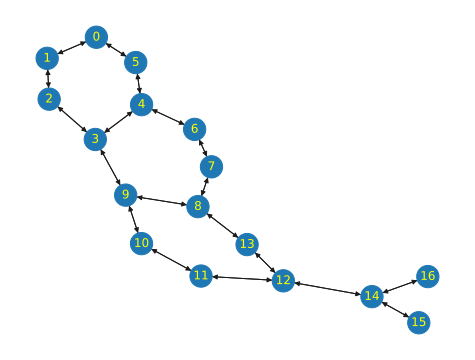

In [35]:
draw_jraph_graph_structure(g)

In [36]:
def apply_simplified_gcn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  # Unpack GraphsTuple
  nodes, _, receivers, senders, _, _, _ = graph

  # 1. Update node features
  # For simplicity, we will first use an identify function here, and replace it
  # with a trainable MLP block later.
  update_node_fn = lambda nodes: nodes
  nodes = update_node_fn(nodes)

  # 2. Aggregate node features over nodes in neighborhood
  # Equivalent to jnp.sum(n_node), but jittable
  total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
  aggregate_nodes_fn = jax.ops.segment_sum

  # Compute new node features by aggregating messages from neighboring nodes
  nodes = tree.tree_map(lambda x: aggregate_nodes_fn(x[senders], receivers,
                                        total_num_nodes), nodes)
  out_graph = graph._replace(nodes=nodes)
  return out_graph

In [37]:
# Download jraph version of Cora.
!wget -P /tmp/ https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/cora.pickle
with open('/tmp/cora.pickle', 'rb') as f:
  cora_ds = pickle.load(f)

--2024-02-13 19:57:59--  https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/cora.pickle
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c03::cf, 2607:f8b0:4023:c0b::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15618018 (15M) [application/octet-stream]
Saving to: ‘/tmp/cora.pickle’

cora.pickle         100%[===================>]  14.89M  --.-KB/s    in 0.09s   

2024-02-13 19:58:00 (171 MB/s) - ‘/tmp/cora.pickle’ saved [15618018/15618018]



In [38]:
def train_val_test_split_edges(graph: jraph.GraphsTuple,
                               val_perc: float = 0.05,
                               test_perc: float = 0.1):
  """Split edges in input graph into train, val and test splits.

  For val and test sets, also include negative edges.
  Based on torch_geometric.utils.train_test_split_edges.
  """
  mask = graph.senders < graph.receivers
  senders = graph.senders[mask]
  receivers = graph.receivers[mask]
  num_val = int(val_perc * senders.shape[0])
  num_test = int(test_perc * senders.shape[0])
  permuted_indices = onp.random.permutation(range(senders.shape[0]))
  senders = senders[permuted_indices]
  receivers = receivers[permuted_indices]
  if graph.edges is not None:
    edges = graph.edges[permuted_indices]

  val_senders = senders[:num_val]
  val_receivers = receivers[:num_val]
  if graph.edges is not None:
    val_edges = edges[:num_val]

  test_senders = senders[num_val:num_val + num_test]
  test_receivers = receivers[num_val:num_val + num_test]
  if graph.edges is not None:
    test_edges = edges[num_val:num_val + num_test]

  train_senders = senders[num_val + num_test:]
  train_receivers = receivers[num_val + num_test:]
  train_edges = None
  if graph.edges is not None:
    train_edges = edges[num_val + num_test:]

  # make training edges undirected by adding reverse edges back in
  train_senders_undir = jnp.concatenate((train_senders, train_receivers))
  train_receivers_undir = jnp.concatenate((train_receivers, train_senders))
  train_senders = train_senders_undir
  train_receivers = train_receivers_undir

  # Negative edges.
  num_nodes = graph.n_node[0]
  # Create a negative adjacency mask, s.t. mask[i, j] = True iff edge i->j does
  # not exist in the original graph.
  neg_adj_mask = onp.ones((num_nodes, num_nodes), dtype=onp.uint8)
  # upper triangular part
  neg_adj_mask = onp.triu(neg_adj_mask, k=1)
  neg_adj_mask[graph.senders, graph.receivers] = 0
  neg_adj_mask = neg_adj_mask.astype(bool)
  neg_senders, neg_receivers = neg_adj_mask.nonzero()

  perm = onp.random.permutation(range(len(neg_senders)))
  neg_senders = neg_senders[perm]
  neg_receivers = neg_receivers[perm]

  val_neg_senders = neg_senders[:num_val]
  val_neg_receivers = neg_receivers[:num_val]
  test_neg_senders = neg_senders[num_val:num_val + num_test]
  test_neg_receivers = neg_receivers[num_val:num_val + num_test]

  train_graph = jraph.GraphsTuple(
      nodes=graph.nodes,
      edges=train_edges,
      senders=train_senders,
      receivers=train_receivers,
      n_node=graph.n_node,
      n_edge=jnp.array([len(train_senders)]),
      globals=graph.globals)

  return train_graph, neg_adj_mask, val_senders, val_receivers, val_neg_senders, val_neg_receivers, test_senders, test_receivers, test_neg_senders, test_neg_receivers

In [39]:
graph = cora_ds[0]['input_graph']

train_graph, neg_adj_mask, val_pos_senders, val_pos_receivers, val_neg_senders, val_neg_receivers, test_pos_senders, test_pos_receivers, test_neg_senders, test_neg_receivers = train_val_test_split_edges(graph)

In [40]:
print(f'Train set: {train_graph.senders.shape[0]} positive edges, we will sample the same number of negative edges at runtime')
print(f'Val set: {val_pos_senders.shape[0]} positive edges, {val_neg_senders.shape[0]} negative edges')
print(f'Test set: {test_pos_senders.shape[0]} positive edges, {test_neg_senders.shape[0]} negative edges')
print(f'Negative adjacency mask shape: {neg_adj_mask.shape}')
print(f'Numbe of negative edges to sample from: {neg_adj_mask.sum()}')

Train set: 8976 positive edges, we will sample the same number of negative edges at runtime
Val set: 263 positive edges, 263 negative edges
Test set: 527 positive edges, 527 negative edges
Negative adjacency mask shape: (2708, 2708)
Numbe of negative edges to sample from: 3660000


In [41]:
@jraph.concatenated_args
def node_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Node update function for graph net."""
  net = hk.Sequential([hk.Linear(128), jax.nn.relu, hk.Linear(64)])
  return net(feats)


def net_fn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Network definition."""
  graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))
  net = jraph.GraphNetwork(
      update_node_fn=node_update_fn, update_edge_fn=None, update_global_fn=None)
  return net(graph)


def decode(pred_graph: jraph.GraphsTuple, senders: jnp.ndarray,
           receivers: jnp.ndarray) -> jnp.ndarray:
  """Given a set of candidate edges, take dot product of respective nodes.

  Args:
    pred_graph: input graph.
    senders: Senders of candidate edges.
    receivers: Receivers of candidate edges.

  Returns:
    For each edge, computes dot product of the features of the two nodes.

  """
  return jnp.squeeze(
      jnp.sum(pred_graph.nodes[senders] * pred_graph.nodes[receivers], axis=1))

In [42]:
from sklearn.metrics import roc_auc_score

def compute_bce_with_logits_loss(x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
  """Computes binary cross-entropy with logits loss.

  Combines sigmoid and BCE, and uses log-sum-exp trick for numerical stability.
  See https://stackoverflow.com/a/66909858 if you want to learn more.

  Args:
    x: Predictions (logits).
    y: Labels.

  Returns:
    Binary cross-entropy loss with mean aggregation.

  """
  max_val = jnp.clip(x, 0, None)
  loss = x - x * y + max_val + jnp.log(
      jnp.exp(-max_val) + jnp.exp((-x - max_val)))
  return loss.mean()


def compute_loss(params: hk.Params, graph: jraph.GraphsTuple,
                 senders: jnp.ndarray, receivers: jnp.ndarray,
                 labels: jnp.ndarray,
                 net: hk.Transformed) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Computes loss."""
  pred_graph = net.apply(params, graph)
  preds = decode(pred_graph, senders, receivers)
  loss = compute_bce_with_logits_loss(preds, labels)
  return loss, preds


def compute_roc_auc_score(preds: jnp.ndarray,
                          labels: jnp.ndarray) -> jnp.ndarray:
  """Computes roc auc (area under the curve) score for classification."""
  s = jax.nn.sigmoid(preds)
  roc_auc = roc_auc_score(labels, s)
  return roc_auc

In [43]:
import jax.numpy as jnp
from typing import Tuple
import jax

def negative_sampling(
    graph: jraph.GraphsTuple, num_neg_samples: int,
    key: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Samples negative edges, i.e. edges that don't exist in the input graph."""
  num_nodes = graph.n_node[0]
  total_possible_edges = num_nodes**2
  # convert 2D edge indices to 1D representation.
  pos_idx = graph.senders * num_nodes + graph.receivers

  # Percentage to oversample edges, so most likely will sample enough neg edges.
  alpha = jnp.abs(1 / (1 - 1.1 *
                       (graph.senders.shape[0] / total_possible_edges)))

  perm = jax.random.randint(
      key,
      shape=(int(alpha * num_neg_samples),),
      minval=0,
      maxval=total_possible_edges,
      dtype=jnp.uint32)

  # mask where sampled edges are positive edges.
  mask = jnp.isin(perm, pos_idx)
  # remove positive edges.
  perm = perm[~mask][:num_neg_samples]

  # convert 1d back to 2d edge indices.
  neg_senders = perm // num_nodes
  neg_receivers = perm % num_nodes

  return neg_senders, neg_receivers


In [44]:
def train(dataset: List[Dict[str, Any]], num_epochs: int) -> hk.Params:
  """Training loop."""
  key = jax.random.PRNGKey(42)
  # Transform impure `net_fn` to pure functions with hk.transform.
  net = hk.without_apply_rng(hk.transform(net_fn))
  # Get a candidate graph and label to initialize the network.
  graph = dataset[0]['input_graph']

  train_graph, _, val_pos_s, val_pos_r, val_neg_s, val_neg_r, test_pos_s, \
      test_pos_r, test_neg_s, test_neg_r = train_val_test_split_edges(
      graph)

  # Prepare the validation and test data.
  val_senders = jnp.concatenate((val_pos_s, val_neg_s))
  val_receivers = jnp.concatenate((val_pos_r, val_neg_r))
  val_labels = jnp.concatenate(
      (jnp.ones(len(val_pos_s)), jnp.zeros(len(val_neg_s))))
  test_senders = jnp.concatenate((test_pos_s, test_neg_s))
  test_receivers = jnp.concatenate((test_pos_r, test_neg_r))
  test_labels = jnp.concatenate(
      (jnp.ones(len(test_pos_s)), jnp.zeros(len(test_neg_s))))
  # Initialize the network.
  params = net.init(key, train_graph)
  # Initialize the optimizer.
  opt_init, opt_update = optax.adam(1e-4)
  opt_state = opt_init(params)

  compute_loss_fn = functools.partial(compute_loss, net=net)
  # We jit the computation of our loss, since this is the main computation.
  # Using jax.jit means that we will use a single accelerator. If you want
  # to use more than 1 accelerator, use jax.pmap. More information can be
  # found in the jax documentation.
  compute_loss_fn = jax.jit(jax.value_and_grad(compute_loss_fn, has_aux=True))

  for epoch in range(num_epochs):
    num_neg_samples = train_graph.senders.shape[0]
    train_neg_senders, train_neg_receivers = negative_sampling(
        train_graph, num_neg_samples=num_neg_samples, key=key)
    train_senders = jnp.concatenate((train_graph.senders, train_neg_senders))
    train_receivers = jnp.concatenate(
        (train_graph.receivers, train_neg_receivers))
    train_labels = jnp.concatenate(
        (jnp.ones(len(train_graph.senders)), jnp.zeros(len(train_neg_senders))))

    (train_loss,
     train_preds), grad = compute_loss_fn(params, train_graph, train_senders,
                                          train_receivers, train_labels)

    updates, opt_state = opt_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    if epoch % 10 == 0 or epoch == (num_epochs - 1):
      train_roc_auc = compute_roc_auc_score(train_preds, train_labels)
      val_loss, val_preds = compute_loss(params, train_graph, val_senders,
                                         val_receivers, val_labels, net)
      val_roc_auc = compute_roc_auc_score(val_preds, val_labels)
      print(f'epoch: {epoch}, train_loss: {train_loss:.3f}, '
            f'train_roc_auc: {train_roc_auc:.3f}, val_loss: {val_loss:.3f}, '
            f'val_roc_auc: {val_roc_auc:.3f}')
  test_loss, test_preds = compute_loss(params, train_graph, test_senders,
                                       test_receivers, test_labels, net)
  test_roc_auc = compute_roc_auc_score(test_preds, test_labels)
  print('Training finished')
  print(
      f'epoch: {epoch}, test_loss: {test_loss:.3f}, test_roc_auc: {test_roc_auc:.3f}'
  )
  return params

In [45]:
params = train(cora_ds, num_epochs=200)

epoch: 0, train_loss: 0.690, train_roc_auc: 0.601, val_loss: 0.691, val_roc_auc: 0.583
epoch: 10, train_loss: 0.685, train_roc_auc: 0.701, val_loss: 0.688, val_roc_auc: 0.631
epoch: 20, train_loss: 0.680, train_roc_auc: 0.760, val_loss: 0.686, val_roc_auc: 0.659
epoch: 30, train_loss: 0.673, train_roc_auc: 0.791, val_loss: 0.682, val_roc_auc: 0.675
epoch: 40, train_loss: 0.663, train_roc_auc: 0.812, val_loss: 0.678, val_roc_auc: 0.691
epoch: 50, train_loss: 0.651, train_roc_auc: 0.834, val_loss: 0.671, val_roc_auc: 0.710
epoch: 60, train_loss: 0.636, train_roc_auc: 0.854, val_loss: 0.662, val_roc_auc: 0.729
epoch: 70, train_loss: 0.617, train_roc_auc: 0.870, val_loss: 0.650, val_roc_auc: 0.747
epoch: 80, train_loss: 0.594, train_roc_auc: 0.883, val_loss: 0.637, val_roc_auc: 0.764
epoch: 90, train_loss: 0.570, train_roc_auc: 0.890, val_loss: 0.621, val_roc_auc: 0.774
epoch: 100, train_loss: 0.545, train_roc_auc: 0.895, val_loss: 0.607, val_roc_auc: 0.783
epoch: 110, train_loss: 0.522, t